In [1]:
# Quantum Trajectories
# Optical Bloch Equations

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dag(array):
    return array.T.conj()

In [3]:
Sx = np.array([[0,1],[1,0]])
Sp = np.array([[0,1],[0,0]])
Sm = dag(Sp)
Es = np.array([1,0])
Gs = np.array([0,1])
I2 = np.array([[1,0],[0,1]])

pE = np.array([[1,0],[0,0]])

Om = 1 # This makes it such that t = t*Om
Δ = 0
Γ = Om/6
g=np.sqrt(Γ)

Hopt = -((Om/2)*Sx)-(Δ*(Sp@Sm))
Heff = Hopt - ((1j*Γ/2)*(Sp@Sm))


In [4]:
Heff

array([[-0. -0.08333333j, -0.5+0.j        ],
       [-0.5+0.j        , -0. +0.j        ]])

In [5]:
np.conj(np.array([1j,1])) == np.array([1j,1]).conj()

array([ True,  True])

In [6]:
def qTrajBlochStep(psi, Heff, dt):
    psi1 = (I2-(1j*Heff*dt))@psi
    dp = psi.conj()@(1j*(Heff-dag(Heff)))@psi*dt
    r = np.random.uniform()
    #print(np.sqrt(dp/dt))
    if r > dp:
        psit = psi1/np.sqrt(psi1.conj()@psi1)
    else:
        psit = np.sqrt(Γ)*Sm@psi/np.sqrt(dp/dt)
    return psit

def qTrajBlochRun(psiI, Heff, dt, Ndt):
    psiC = psiI
    psiL = [psiC]
    for i in range(Ndt):
        psiC = qTrajBlochStep(psiC, Heff, dt)
        psiL.append(psiC)
    return np.array(psiL)

def qTrajBlochRunPee(psiI, Heff, dt, Ndt):
    psiC = psiI
    pL = [psiC@pE@psiC]
    for i in range(Ndt):
        psiC = qTrajBlochStep(psiC, Heff, dt)
        pL.append(psiC.conj()@pE@psiC)
    return np.array(pL)

def BrK(psi, M):
    return np.einsum('ij,ij->i', np.dot(psi,M), psi)

def BlochPeeExact(T):
    return 36*np.exp(-T/8)*(115*np.exp(T/8)-115*np.cos((5/24)*np.sqrt(23)*T)-3*np.sqrt(23)*np.sin((5/24)*np.sqrt(23)*T))/8395

In [7]:
BlochPeeExact(0)

0.0

In [8]:
rN = 1000
pEs = np.array([qTrajBlochRunPee(Gs, Heff, 0.1, 400) for i in range(rN)])

/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


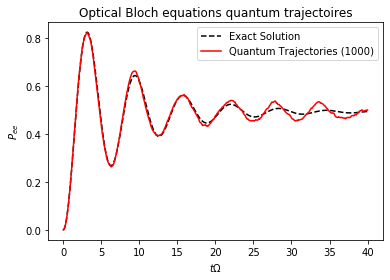

In [9]:
xV = np.linspace(0,40,401)
plt.plot(xV, BlochPeeExact(xV), label='Exact Solution', linestyle='--', color='k' )
plt.plot(xV, np.mean(pEs,axis=0), label='Quantum Trajectories ('+str(rN)+')', linestyle='-', color='r')
plt.legend()
plt.title('Optical Bloch equations quantum trajectoires')
plt.ylabel('$P_{ee}$')
plt.xlabel('$t\Omega$')
plt.savefig("OpticalBlochqT.pdf")
plt.show()

In [10]:
### Ensemple Rank Truncation
from scipy.linalg import expm

# K=1
dt = .1
J = (-1j*Hopt)+((Γ/2)*((Sm@Sm)-(Sp@Sm)))
def Uk(dt):
    return expm((dt*Jk())-(1j*np.sqrt(dt*Γ)*Sm))
def Vk(dt):
    return expm((dt*Jk())+(1j*np.sqrt(dt*Γ)*Sm))
def Jk():
    return (-1j*Hopt)+((Γ/2)*((Sm@Sm)-(Sp@Sm)))

def doERTrun(psiI, Ndt):
    psiS = np.array([psiI])
    pee = [obsPee(psiS)]
    for i in range(Ndt):
        psiS = stepERTens(psiS)
        pee.append(obsPee(psiS))
    return np.array(pee)

def TSize(psiL):
    return np.sum(np.array([psi.conj()@psi for psi in psiL]))
def TS2(psiL):
    return np.sum(np.linalg.norm(psiL,axis=1))
def ASize(psiL):
    return np.mean(np.array([psi.conj()@psi for psi in psiL]))
        
def obsPee(psiL):
    #print('L: ',len(psiL))
    #print('1: ', np.sum(np.array([psi.conj()@pE@psi for psi in psiL])), ' 2: ',np.mean(np.array([psi.conj()@pE@psi for psi in psiL])))
    return np.mean(np.array([psi.conj()@pE@psi for psi in psiL]))

def obsPeeM(psiL):
    return np.mean(np.array([psi.conj()@pE@psi for psi in psiL]))
def obsPeeS(psiL):
    return np.sum(np.array([psi.conj()@pE@psi for psi in psiL]))

def stepERTens(psiL):
    R = 8
    nPsi = []
    #Propagate
    for psi in psiL:
        nPsi.append(Uk(dt)@psi)
        nPsi.append(Vk(dt)@psi)
    #Truncate
    nPsi = np.array(nPsi)
    Sij = np.dot(nPsi.conj(),nPsi.T)
    w, Uuns = np.linalg.eigh(Sij)
    idx = np.argsort(w)[::-1]
    Ulk = Uuns[:,idx]
    #diag_matrix = np.conjugate(Ulk.T) @ Sij @ Ulk
    #print('w: ', w)
    #print('Diag ',np.round(diag_matrix, decimals=10))
    if len(nPsi) > R:
        #UR = Ulk[:,:R]
        UR = Ulk.T.conj()[:R]/np.sqrt(2)
        #print('TUNC')
    else:
        #return nPsi
        UR = Ulk.T.conj()
    #print('Pee: ',obsPee(nPsi))
    #print('nPsi: ',nPsi.shape)
    #print('Ulk: ',Ulk.shape)
    #print('RecPee: ',obsPee(np.array([Ulk@psi for psi in nPsi])))
    #print('RecPee: ',obsPee(Ulk@nPsi))
    #print('psiL: ',nPsi)
    #print('UR: ',UR.T.shape)
    #print('nPsi: ',nPsi.shape)
    #print('rPsi: ',(UR.T.conj()@nPsi).shape)
    #print('1: ', obsPee(nPsi))
    #print('2: ', obsPee(UR.T.conj()@nPsi))
    #print()
    Opsi = Ulk.T.conj()@nPsi
    rPsi = UR@nPsi
    ### "appropriate normalization" whatever the fuck that means
    #rPsi = rPsi/TS2(rPsi)
    #print('1: ', obsPee(rPsi))
    #print(rPsi)
    #for i, psi in enumerate(Opsi):
        #for j, psi2 in enumerate(Opsi):
            #print('('+str(i)+','+str(j)+')',psi.conj()@psi2)
        
    #print('rPsi.shape', rPsi.shape)
   # print('1: ',obsPee(psiL))
    #print('1S: ', obsPeeS(psiL))
    #print('1A: ', obsPeeM(psiL))
   # print('2: ',obsPee(nPsi))
    #print('2S: ', obsPeeS(nPsi))
    #print('2A: ', obsPeeM(nPsi))
   # print('3: ',obsPee(rPsi))
    #print('3S: ', obsPeeS(rPsi))
    #print('3A: ', obsPeeM(rPsi))
    #print('psiL: ',obsPeeM(psiL))
    #print('nPsi: ',obsPeeM(nPsi))
    #print('rPsi: ',obsPeeM(rPsi))
    
    return rPsi
    
    
    
    
        


In [11]:
b = doERTrun(Gs,400)
print(b)

[0.        +0.j 0.00247721+0.j 0.00980233+0.j 0.02178254+0.j
 0.03818329+0.j 0.05873174+0.j 0.08312043+0.j 0.11101115+0.j
 0.14203913+0.j 0.17581731+0.j 0.21194073+0.j 0.24999109+0.j
 0.28954116+0.j 0.33015933+0.j 0.37141399+0.j 0.41287785+0.j
 0.4541321 +0.j 0.49477038+0.j 0.53440251+0.j 0.57265798+0.j
 0.60918922+0.j 0.6436744 +0.j 0.67582011+0.j 0.7053635 +0.j
 0.7320742 +0.j 0.7557558 +0.j 0.77624696+0.j 0.79342216+0.j
 0.8071921 +0.j 0.81750361+0.j 0.82433939+0.j 0.82771723+0.j
 0.82768898+0.j 0.82433919+0.j 0.81778348+0.j 0.80816657+0.j
 0.79566019+0.j 0.78046062+0.j 0.76278617+0.j 0.74287445+0.j
 0.72097951+0.j 0.69736894+0.j 0.67232079+0.j 0.6461206 +0.j
 0.61905837+0.j 0.59142549+0.j 0.56351187+0.j 0.53560304+0.j
 0.50797744+0.j 0.48090379+0.j 0.45463865+0.j 0.4294242 +0.j
 0.40548612+0.j 0.38303179+0.j 0.36224867+0.j 0.34330288+0.j
 0.32633814+0.j 0.31147481+0.j 0.29880934+0.j 0.28841386+0.j
 0.28033604+0.j 0.27459929+0.j 0.27120304+0.j 0.27012342+0.j
 0.271314  +0.j 0.274706

In [12]:
dt = 0.0001
(1/2)*((Uk(dt).T.conj()@Uk(dt))+(Vk(dt).T.conj()@Vk(dt)))

array([[1.+0.00000000e+00j, 0.+1.38888889e-10j],
       [0.-1.38888889e-10j, 1.+0.00000000e+00j]])

In [13]:
Vk(0.0001)

array([[0.99999156+0.00000000e+00j, 0.        +4.99997899e-05j],
       [0.        +4.13246554e-03j, 0.9999999 +0.00000000e+00j]])

In [14]:
TS2(np.array([[0,1],[0.5,0.5],[1,0],[1,0]]))

3.7071067811865475

/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No handles with labels found to put in legend.


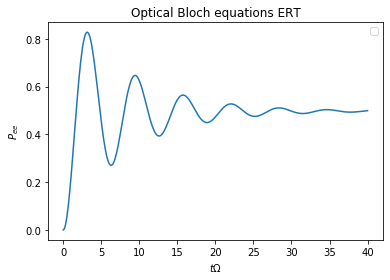

In [15]:
plt.plot(xV, b,)
plt.legend()
plt.title('Optical Bloch equations ERT')
plt.ylabel('$P_{ee}$')
plt.xlabel('$t\Omega$')
plt.savefig("OpticalBlochERT.pdf")


In [16]:
stepERTens([Es,Es,Es,Es], 0.01)

TypeError: stepERTens() takes 1 positional argument but 2 were given

In [ ]:
psi_reconstructed

In [ ]:
import numpy as np

# Example operator (R x L)
O = np.random.rand(3, 4)

# Example wavefunctions (L x 2)
Psi = np.random.rand(4, 2)

# Apply the operator
Phi = O @ Psi

print("Resulting wavefunctions:", Phi)


In [ ]:
np.linalg.norm(Uk(0.1)@Es)